Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Hugging Face Pipeline for MONAI
[Hugging Face](https://huggingface.co/) is a popular open-source platform for natural language processing (NLP) and other machine learning applications. Their tools and libraries are designed to make it easy to use state-of-the-art models for a wide range of tasks. It provides pre-trained models and a user-friendly API, making cutting-edge machine learning accessible to developers and researchers alike.

The [Transformers](https://huggingface.co/docs/transformers/index) library by Hugging Face is a comprehensive collection of pre-trained models for NLP and other tasks. It supports models for text classification, information extraction, question answering, summarization, translation, and more. The library is designed to be user-friendly, allowing users to easily integrate powerful models into their applications with just a few lines of code.

The [Hugging Face Hub](https://huggingface.co/docs/hub/index) is an online platform where users can share and discover pre-trained models. It hosts models for various languages and tasks, enabling collaboration and reuse of models within the machine learning community. The Hub also provides tools for versioning, managing, and deploying models, making it a valuable resource for both developers and researchers.

In this tutorial, a pretrained spleen segmentation model will be wrapped into a pipeline provided by the Transformers library. Following this tutorial, as the figure shown below, users can easily build their own discriminative MONAI models (classification, detection, segmentation) into a transformer pipeline and let others use it as a hugging face native Transformers pipeline transparently to build applications.

<center>
    <img src="../figures/hugging_face_general.jpg" alt="drawing" width=650 />
</center>

## Setup environment 
MONAI installation has the optional dependencies needed for this tutorial. Therefore installing MONAI with necessary optional dependiencies is recommanded for this turtorial.

In [1]:
!python -c "import monai" || pip install -q 'monai[transformers,skimage,nibabel]'

## Setup imports

In [ ]:
import logging

from monai.transforms import (
    Activationsd,
    AsDiscreted,
    EnsureChannelFirstd,
    EnsureTyped,
    Compose,
    LoadImage,
    LoadImaged,
    Orientationd,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    ToNumpy,
    Invertd,
)

from monai.utils.enums import CommonKeys as Keys
from monai.networks.nets import UNet
from monai.networks.utils import eval_mode
from monai.inferers import SlidingWindowInferer
from monai.data import decollate_batch, list_data_collate
from monai.config import print_config
from monai.apps import download_and_extract
from monai.bundle import download
import torch
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import shutil

from transformers import PretrainedConfig, PreTrainedModel, Pipeline

print_config()

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.4.0
Numpy version: 1.24.4
Pytorch version: 2.5.0a0+872d972e41.nv24.08
MONAI flags: HAS_EXT = True, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /opt/monai/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.4.0
Nibabel version: 5.3.1
scikit-image version: 0.24.0
scipy version: 1.14.0
Pillow version: 10.4.0
Tensorboard version: 2.16.2
gdown version: 5.2.0
TorchVision version: 0.20.0a0
tqdm version: 4.66.5
lmdb version: 1.5.1
psutil version: 6.0.0
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.40.2
mlflow version: 2.17.0
pynrrd version: 1.0.0
clearml version: 1.16.5rc2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable. This allows you to save results and reuse downloads. If not specified a temporary directory will be used.

In [ ]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

## Download dataset

Downloads and extracts the dataset. The dataset comes from http://medicaldecathlon.com/.

In [4]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

## Get inference dataset

In [5]:
images = sorted(glob.glob(os.path.join(data_dir, "imagesTs", "*.nii.gz")))
data_dicts = [{"image": image_name} for image_name in images]

## Define the model configuration

A PretrainedConfig in Hugging Face's Transformers library is a class that holds the configuration parameters for a model. This configuration includes information such as model architecture details, hyperparameters, and other settings that define how the model behaves. The PretrainedConfig is used to initialize a model with a specific configuration or to load a model's configuration from a pre-trained checkpoint.

In this section, a MONAI UNet configuration will be defined for the UNet initialization.

In [6]:
class MONAIUNetConfig(PretrainedConfig):
    model_type = "monai_unet"

    def __init__(
        self,
        spatial_dims=3,
        in_channels=1,
        out_channels=2,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
        norm="batch",
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.spatial_dims = spatial_dims
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.channels = channels
        self.strides = strides
        self.num_res_units = num_res_units
        self.norm = norm

## Define a hugging face pretrained model

A PreTrainedModel in Hugging Face's Transformers library is a base class for all model classes. It provides common functionalities for loading, saving, and configuring models. This class is designed to work seamlessly with PretrainedConfig, allowing users to load pre-trained models from the Hugging Face Hub or from local files. The PreTrainedModel class ensures consistency and ease of use across different model architectures. Here is a figure to show the PreTrainedModel details.

<center>
    <img src="../figures/hugging_face_model.jpg" alt="drawing" width=500 />
</center>

In this section, we will define a pretrained MONAI UNet class which will load the configuration defined before for initialization.

In [7]:
class MONAIUNet(PreTrainedModel):
    config_class = MONAIUNetConfig

    def __init__(self, config):
        super().__init__(config)
        self.unet = UNet(
            spatial_dims=config.spatial_dims,
            in_channels=config.in_channels,
            out_channels=config.out_channels,
            channels=config.channels,
            strides=config.strides,
            num_res_units=config.num_res_units,
            norm=config.norm,
        )

    def forward(self, x):
        return self.unet(x)

## Build a hugging face pipeline

A Hugging Face pipeline is a high-level API that simplifies the process of using pre-trained models for various tasks such as text classification, image classification, object detection, and more. It abstracts the complexity of loading models and tokenizers, making it easy to perform inference with just a few lines of code. The pipeline handles the preprocessing of inputs, passing data through the model, and post-processing of outputs as illustrated below.

<center>
    <img src="../figures/hugging_face_pipeline.jpg" alt="drawing" width=800 />
</center>

This section will illustrate how to build a hugging face pipeline based on the pretrained model.

In [8]:
class SpleenCTSegmentationPipeline(Pipeline):
    PREPROCESSING_EXTRA_ARGS = [
        "image_key",
        "load_image",
    ]
    INFERENCE_EXTRA_ARGS = [
        "mode",
        "amp",
        "hyper_kwargs",
        "roi_size",
        "overlap",
        "sw_batch_size",
        "use_point_window",
    ]
    POSTPROCESSING_EXTRA_ARGS = [
        "pred_key",
        "image_key",
        "output_dir",
        "output_ext",
        "output_postfix",
        "separate_folder",
        "save_output",
    ]

    def __init__(self, model, **kwargs):
        super().__init__(model=model, **kwargs)
        self.model = model
        self.preprocessing_transforms = self._init_preprocessing_transforms(**self._preprocess_params)
        self.inferer = self._init_inferer(**self._forward_params)
        self.postprocessing_transforms = self._init_postprocessing_transforms(**self._postprocess_params)

    def _init_preprocessing_transforms(self, image_key=Keys.IMAGE, load_image=True):
        transform_list = [LoadImaged(keys=image_key)] if load_image else []
        transform_list.extend(
            [
                EnsureChannelFirstd(keys=image_key),
                Orientationd(keys=image_key, axcodes="RAS"),
                Spacingd(keys=image_key, pixdim=(1.5, 1.5, 2.0), mode="bilinear"),
                ScaleIntensityRanged(keys=image_key, a_min=-57, a_max=164, b_min=0, b_max=1, clip=True),
                EnsureTyped(keys=image_key),
            ]
        )
        preprocessing_transforms = Compose(transform_list)
        return preprocessing_transforms

    def _init_postprocessing_transforms(
        self,
        pred_key: str = Keys.PRED,
        image_key: str = Keys.IMAGE,
        output_dir: str = "output_directory",
        output_ext: str = ".nii.gz",
        output_dtype: torch.dtype = torch.float32,
        output_postfix: str = "seg",
        separate_folder: bool = True,
        save_output: bool = True,
    ):
        transform_list = [
            Activationsd(keys=pred_key, softmax=True),
            Invertd(
                keys=pred_key,
                transform=self.preprocessing_transforms,
                orig_keys=image_key,
                nearest_interp=False,
                to_tensor=True,
            ),
            AsDiscreted(keys=pred_key, argmax=True),
        ]

        (
            transform_list.append(
                SaveImaged(
                    keys=pred_key,
                    output_dir=output_dir,
                    output_ext=output_ext,
                    output_dtype=output_dtype,
                    output_postfix=output_postfix,
                    separate_folder=separate_folder,
                )
            )
            if save_output
            else transform_list
        )
        postprocessing_transforms = Compose(transform_list)
        return postprocessing_transforms

    def _init_inferer(
        self,
        roi_size=(96, 96, 96),
        overlap=0.5,
        sw_batch_size=4,
    ):
        return SlidingWindowInferer(roi_size=roi_size, sw_batch_size=sw_batch_size, overlap=overlap)

    def _sanitize_parameters(self, **kwargs):
        preprocessing_kwargs = {}
        infer_kwargs = {}
        postprocessing_kwargs = {}
        for key in self.INFERENCE_EXTRA_ARGS:
            if key in kwargs:
                infer_kwargs[key] = kwargs[key]

        for key in self.PREPROCESSING_EXTRA_ARGS:
            if key in kwargs:
                preprocessing_kwargs[key] = kwargs[key]

        for key in self.POSTPROCESSING_EXTRA_ARGS:
            if key in kwargs:
                postprocessing_kwargs[key] = kwargs[key]

        return (preprocessing_kwargs, infer_kwargs, postprocessing_kwargs)

    def preprocess(
        self,
        inputs,
        **kwargs,
    ):
        for key, value in kwargs.items():
            if key in self._preprocess_params and value != self._preprocess_params[key]:
                logging.warning(f"Please set the parameter {key} during initialization.")

            if key not in self.PREPROCESSING_EXTRA_ARGS:
                logging.warning(f"Cannot set parameter {key} for preprocessing.")
        inputs = self.preprocessing_transforms(inputs)
        inputs = list_data_collate([inputs])
        return inputs

    def _forward(
        self,
        inputs,
        amp: bool = True,
    ):
        inputs[Keys.IMAGE].to(self.device)
        self.model.unet.to(self.device)
        mode = eval_mode
        with mode(self.model):
            if amp:
                with torch.autocast("cuda"):
                    inputs[Keys.PRED] = self.inferer(inputs[Keys.IMAGE], self.model)
            else:
                inputs[Keys.PRED] = self.inferer(inputs[Keys.IMAGE], self.model)
        return inputs

    def postprocess(self, outputs, **kwargs):
        for key, value in kwargs.items():
            if key not in self.POSTPROCESSING_EXTRA_ARGS:
                logging.warning(f"Cannot set parameter {key} for postprocessing.")
            if (key in self._postprocess_params and value != self._postprocess_params[key]) or (
                key not in self._postprocess_params
            ):
                self._postprocess_params.update(kwargs)
                self.postprocessing_transforms = self._init_postprocessing_transforms(**self._postprocess_params)
        outputs = decollate_batch(outputs)
        outputs = self.postprocessing_transforms(outputs)
        return outputs

## Run pipeline

In this section, we will instantiate the pipeline, load the pretrained weight and run inference with it.

2025-03-14 12:21:39,435 - INFO - --- input summary of monai.bundle.scripts.download ---
2025-03-14 12:21:39,435 - INFO - > name: 'spleen_ct_segmentation'
2025-03-14 12:21:39,435 - INFO - > bundle_dir: '.'
2025-03-14 12:21:39,436 - INFO - > source: 'monaihosting'
2025-03-14 12:21:39,436 - INFO - > remove_prefix: 'monai_'
2025-03-14 12:21:39,437 - INFO - > progress: False
2025-03-14 12:21:39,437 - INFO - ---


2025-03-14 12:21:40,325 - INFO - Expected md5 is None, skip md5 check for file spleen_ct_segmentation_v0.5.9.zip.
2025-03-14 12:21:40,327 - INFO - File exists: spleen_ct_segmentation_v0.5.9.zip, skipped downloading.
2025-03-14 12:21:40,329 - INFO - Writing into directory: ..


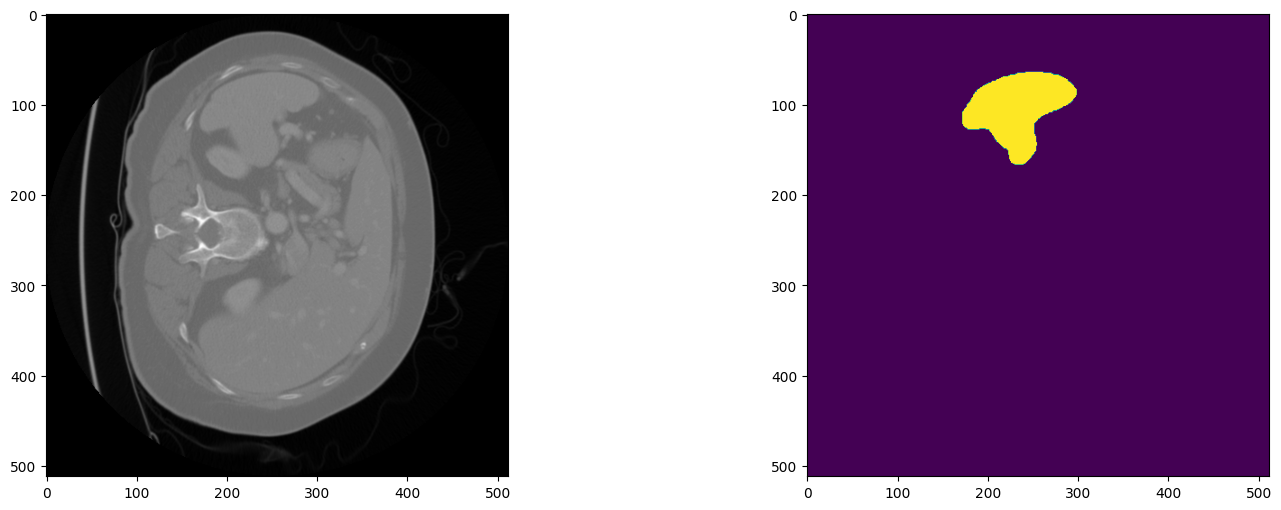

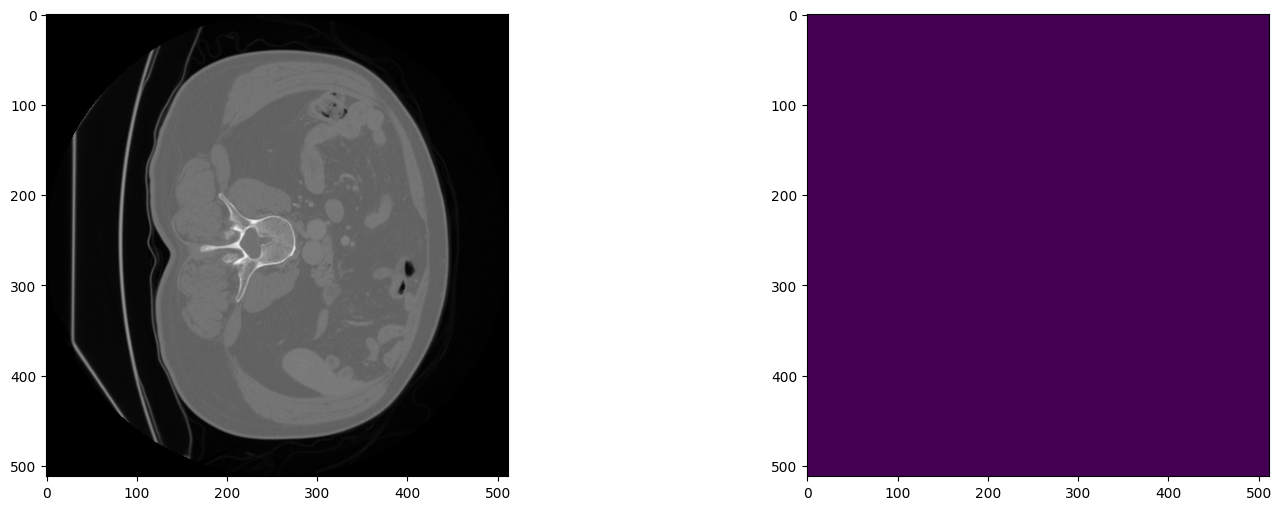

In [9]:
bundle_dir = "."
os.makedirs(bundle_dir, exist_ok=True)
download("spleen_ct_segmentation", bundle_dir=bundle_dir, progress=False)
weight_dir = os.path.join(bundle_dir, "spleen_ct_segmentation/models/model.pt")

config = MONAIUNetConfig()
monai_unet = MONAIUNet(config)
monai_unet.unet.load_state_dict(torch.load(weight_dir, weights_only=True))
pipeline = SpleenCTSegmentationPipeline(model=monai_unet, device=torch.device("cuda:0"), save_output=False)

numpy_transform = ToNumpy()
loader = LoadImage()


def convert_to_numpy(input):
    numpy_output = numpy_transform(input)
    numpy_output = np.squeeze(numpy_output, axis=0)
    return numpy_output


with torch.no_grad():
    test_outputs = pipeline(data_dicts[:2])
    for test_output in test_outputs:
        original_image = loader(test_output[0]["image"].meta["filename_or_obj"])
        pred_output = convert_to_numpy(test_output[0]["pred"])

        plt.figure("check", (18, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image[:, :, 20], cmap="gray")
        plt.subplot(1, 2, 2)
        plt.imshow(pred_output[:, :, 20])
        plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [10]:
if directory is None:
    shutil.rmtree(root_dir)